In [30]:
import time
import math
from typing import List, Optional, Tuple
import seaborn as sns
import ccxt
import pandas as pd
import numpy as np
# === Celda ipynb: Generar y escalar todas las features TA-Lib (pegar después de tu código de descarga) ===
import os
import json
import warnings
from typing import Dict, List, Tuple, Optional

import pandas as pd
import numpy as np

import sys
import subprocess

def ensure_package(pkg_name: str, pip_name: str = None):
    try:
        __import__(pkg_name)
    except ImportError:
        print(f"Instalando {pip_name or pkg_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name or pkg_name])

# Intentar instalar TA-Lib desde pip
try:
    import talib  # noqa
except ImportError:
    ensure_package("talib", "TA-Lib>=0.4.28")

# Verificación de import
import talib
from talib import abstract as ta_abstract

print(f"TA-Lib versión: {talib.__version__}")
import joblib
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


TA-Lib versión: 0.6.7


In [31]:
# Parámetros principales (editar aquí)
ASSET = "EUR"               # Opciones: "BTC", "ETH", "SOL"
QUOTE = "USDT"              # Se puede cambiar a "USD" si el exchange lo soporta
TIMEFRAME = "1d"            # Opciones soportadas: "1h", "1d"
EXCHANGE_ID = "binance"     # Fuente de datos via ccxt (default: binance)


# Paginación y rate limiting
WINDOW_LIMIT = 1000         # Número de velas por llamada (típicamente 500-1000 en muchos exchanges)
API_PAUSE_SECONDS = 0.25    # Pausa entre llamadas (se suma al rateLimit interno si enableRateLimit=True)
MAX_RETRIES = 5             # Reintentos por error de red / rate limiting
RETRY_BACKOFF = 1.5         # Factor de backoff exponencial para reintentos


# Rango temporal inicial (None = descargar desde el inicio disponible del exchange)
# Puedes establecer una fecha para empezar (e.g., "2017-01-01")
START_DATE: Optional[str] = None


# Validación básica
assert ASSET in {"BTC", "ETH", "SOL", "EUR"}, "ASSET debe ser 'BTC', 'ETH' o 'SOL'"
assert TIMEFRAME in {"1h", "1d"}, "TIMEFRAME debe ser '1h' o '1d'"


SYMBOL = f"{ASSET}/{QUOTE}"
print(f"Configuración: symbol={SYMBOL}, timeframe={TIMEFRAME}, exchange={EXCHANGE_ID}")
# Crear instancia del exchange con rate limiting activado
exchange_class = getattr(ccxt, EXCHANGE_ID)
exchange = exchange_class({
    "enableRateLimit": True,                 # Throttling interno de ccxt
    "timeout": 30000,                        # 30s de timeout
    "options": {
        "adjustForTimeDifference": True
    }
})


# Cargar mercados y validar símbolo/timeframe
markets = exchange.load_markets()
if SYMBOL not in markets:
    raise ValueError(f"El símbolo {SYMBOL} no existe en {EXCHANGE_ID}. "
                     f"Verifica que el par con {QUOTE} está disponible en este exchange.")


if not exchange.has.get("fetchOHLCV", False):
    raise RuntimeError(f"El exchange {EXCHANGE_ID} no soporta fetchOHLCV en ccxt.")


# Validar timeframe soportado por el exchange
if TIMEFRAME not in exchange.timeframes:
    raise ValueError(f"El timeframe {TIMEFRAME} no está soportado por {EXCHANGE_ID}. "
                     f"Timeframes disponibles: {list(exchange.timeframes.keys())[:20]} ...")
def timeframe_to_millis(ex: ccxt.Exchange, timeframe: str) -> int:
    # ccxt.parse_timeframe devuelve segundos
    return int(ex.parse_timeframe(timeframe) * 1000)


def parse_start_date_to_ms(start_date: Optional[str], ex: ccxt.Exchange) -> int:
    if start_date is None:
        return 0  # Intentar desde el inicio disponible
    # Convertir string a timestamp ms (UTC)
    return int(pd.Timestamp(start_date, tz="UTC").timestamp() * 1000)


def fetch_ohlcv_paginated(
    ex: ccxt.Exchange,
    symbol: str,
    timeframe: str,
    start_ms: int,
    window_limit: int = 1000,
    pause_seconds: float = 0.25,
    max_retries: int = 5,
    retry_backoff: float = 1.5,
    verbose: bool = True
) -> List[List[float]]:
    """
    Descarga todo el histórico disponible desde 'start_ms' en adelante,
    usando paginación por ventanas (limit) y pausas entre llamadas.
    Retorna una lista de filas OHLCV: [timestamp, open, high, low, close, volume]
    """
    tf_ms = timeframe_to_millis(ex, timeframe)
    all_rows: List[List[float]] = []
    since = start_ms
    last_ts_obtained: Optional[int] = None
    calls = 0


    while True:
        # Reintentos con backoff
        attempt = 0
        while True:
            try:
                batch = ex.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=window_limit)
                break
            except (ccxt.RateLimitExceeded, ccxt.RequestTimeout, ccxt.NetworkError) as e:
                if attempt >= max_retries:
                    raise
                sleep_for = (ex.rateLimit / 1000.0) + (pause_seconds * (retry_backoff ** attempt))
                if verbose:
                    print(f"[WARN] {type(e).__name__}: {e}. Reintentando en {sleep_for:.2f}s (intento {attempt+1}/{max_retries})")
                time.sleep(sleep_for)
                attempt += 1


        calls += 1


        if not batch:
            if verbose:
                print("No se recibieron más velas. Fin de descarga.")
            break


        # Asumimos orden ascendente por timestamp (ccxt lo entrega así usualmente)
        batch_first_ts = batch[0][0]
        batch_last_ts = batch[-1][0]


        # Evitar loops si el exchange no avanza (misma última vela)
        if last_ts_obtained is not None and batch_last_ts <= last_ts_obtained:
            # Forzar avance mínimo
            since = last_ts_obtained + tf_ms
            # Si aún así no hay avance, salimos
            if verbose:
                print("[INFO] No hay progreso adicional en timestamps. Deteniendo.")
            break


        all_rows.extend(batch)
        last_ts_obtained = batch_last_ts


        # Progreso simple
        if verbose and (calls % 10 == 0 or len(batch) < window_limit):
            start_dt = pd.to_datetime(all_rows[0][0], unit="ms", utc=True).tz_convert("UTC")
            end_dt = pd.to_datetime(last_ts_obtained, unit="ms", utc=True).tz_convert("UTC")
            print(f"[{calls:04d}] Acumuladas: {len(all_rows):>7} velas | Rango: {start_dt} -> {end_dt}")


        # Si llega menos que el límite, probablemente alcanzamos el final disponible
        if len(batch) < window_limit:
            # Intentar un pequeño avance y ver si hay más (opcional). Aquí finalizamos por simplicidad/seguridad.
            if verbose:
                print("Último lote menor al límite: se asume fin del histórico disponible.")
            break


        # Avanzar ventana al siguiente bloque
        since = batch_last_ts + tf_ms


        # Pausa para respetar límites (además del rateLimit interno)
        effective_pause = max(pause_seconds, ex.rateLimit / 1000.0)
        time.sleep(effective_pause)


    # Deduplicar por timestamp (por seguridad)
    # Mantener el primer registro por timestamp
    if all_rows:
        # Usar dict para deduplicar rápido
        unique = {}
        for row in all_rows:
            unique[row[0]] = row
        all_rows = [unique[k] for k in sorted(unique.keys())]


    return all_rows
start_ms = parse_start_date_to_ms(START_DATE, exchange)
print(f"Iniciando descarga para {SYMBOL} @ {TIMEFRAME} desde {start_ms} ms (UTC: {pd.to_datetime(start_ms, unit='ms', utc=True) if start_ms>0 else 'inicio disponible'})")


ohlcv_rows = fetch_ohlcv_paginated(
    ex=exchange,
    symbol=SYMBOL,
    timeframe=TIMEFRAME,
    start_ms=start_ms,
    window_limit=WINDOW_LIMIT,
    pause_seconds=API_PAUSE_SECONDS,
    max_retries=MAX_RETRIES,
    retry_backoff=RETRY_BACKOFF,
    verbose=True
)


# Convertir a DataFrame ordenado
if not ohlcv_rows:
    raise RuntimeError("No se descargaron datos. Verifica símbolo, timeframe o límites del exchange.")


df_ohlcv = pd.DataFrame(ohlcv_rows, columns=["timestamp", "open", "high", "low", "close", "volume"])
df_ohlcv = df_ohlcv.sort_values("timestamp").drop_duplicates(subset=["timestamp"]).reset_index(drop=True)
df_ohlcv["datetime"] = pd.to_datetime(df_ohlcv["timestamp"], unit="ms", utc=True)


print(f"Total velas descargadas: {len(df_ohlcv)} | Rango: {df_ohlcv['datetime'].min()} -> {df_ohlcv['datetime'].max()}")

Configuración: symbol=EUR/USDT, timeframe=1d, exchange=binance
Iniciando descarga para EUR/USDT @ 1d desde 0 ms (UTC: inicio disponible)
[0003] Acumuladas:    2105 velas | Rango: 2020-01-03 00:00:00+00:00 -> 2025-10-07 00:00:00+00:00
Último lote menor al límite: se asume fin del histórico disponible.
Total velas descargadas: 2105 | Rango: 2020-01-03 00:00:00+00:00 -> 2025-10-07 00:00:00+00:00


In [32]:
import numpy as np
import pandas as pd
import talib as ta

def _assign_talib_result(df: pd.DataFrame, base_name: str, result, suffixes=None):
    """
    Asigna el resultado de una llamada a TA-Lib a columnas del DataFrame `df`.
    - Si `result` es un array 1D -> crea df[base_name] = array (ajusta/paddea si es necesario).
    - Si `result` es una tupla/list -> crea columnas base_name + '_' + suffix para cada elemento.
      Si `suffixes` no es None se usan, si no se usan sufijos numéricos (_0, _1, ...).
    El ajuste/padding intenta ser tolerante: si la longitud devuelta es menor que len(df),
    se rellenan los primeros valores con NaN; si es mayor, se truncan (se usan los últimos n).
    """
    n = len(df)
    def _normalize_arr(arr):
        arr = np.asarray(arr)
        # Escala 0-d a vector
        if arr.ndim == 0:
            return np.full(n, arr.item(), dtype=float)
        if arr.ndim > 1:
            arr = arr.ravel()
        m = arr.shape[0]
        if m == n:
            return arr.astype(float)
        if m == 1:
            return np.full(n, arr.item(), dtype=float)
        if m < n:
            # pad at inicio con NaN para alinear como TA-Lib suele devolver vectores más cortos
            pad = np.full(n - m, np.nan, dtype=float)
            return np.concatenate([pad, arr.astype(float)])
        # m > n -> trunca los últimos n (asume que las últimas son las más relevantes)
        return arr[-n:].astype(float)

    if isinstance(result, (tuple, list)):
        k = len(result)
        if suffixes is None:
            suffixes = [str(i) for i in range(k)]
        for idx, (arr, suf) in enumerate(zip(result, suffixes)):
            df[f"{base_name}_{suf}"] = _normalize_arr(arr)
    else:
        df[base_name] = _normalize_arr(result)


def compute_all_talib_indicators(df_ohlcv: pd.DataFrame) -> pd.DataFrame:
    """
    Calcula una amplia colección de indicadores TA-Lib y los añade al DataFrame.
    Requiere columnas: 'open','high','low','close','volume' (nombres exactos).
    Devuelve un DataFrame con las columnas originales y las nuevas columnas de indicadores.
    """
    df = df_ohlcv.copy().reset_index(drop=True)  # trabajar con índices simples
    n = len(df)

    # Asegurar tipo float para TA-Lib y extraer vectores
    open_ = df["open"].astype(float).values
    high = df["high"].astype(float).values
    low = df["low"].astype(float).values
    close = df["close"].astype(float).values
    volume = df["volume"].astype(float).values

    # Helpers numéricos para dominios
    c_min, c_max = np.nanmin(close), np.nanmax(close)
    denom = (c_max - c_min) if (c_max - c_min) != 0 else 1.0
    close_norm = np.clip(((close - c_min) / denom) * 2.0 - 1.0, -1.0, 1.0)  # [-1, 1] p/ ACOS/ASIN
    close_pos = np.where(close > 0, close, np.nan)
    close_nonneg = np.where(close >= 0, close, np.nan)
    close_nonneg_sqrt = np.where(close >= 0, close, np.nan)

    # Periodos por defecto típicos
    P_DEF = 14
    P_MA = 30
    P_SHORT = 12
    P_LONG = 26
    P_SIGNAL = 9

    # DataFrame de features (comenzamos con copia de originales)
    feats = df.copy()

    # =========================
    # Cycle Indicators (Hilbert)
    # =========================
    _ = ta.HT_DCPERIOD(close); _assign_talib_result(feats, "HT_DCPERIOD", _)
    _ = ta.HT_DCPHASE(close); _assign_talib_result(feats, "HT_DCPHASE", _)
    _inphase, _quadrature = ta.HT_PHASOR(close); _assign_talib_result(feats, "HT_PHASOR", (_inphase, _quadrature),
                                                                          suffixes=["inphase", "quadrature"])
    _sine, _leadsine = ta.HT_SINE(close); _assign_talib_result(feats, "HT_SINE", (_sine, _leadsine),
                                                                suffixes=["sine", "leadsine"])
    _ = ta.HT_TRENDMODE(close); _assign_talib_result(feats, "HT_TRENDMODE", _)

    # =========================
    # Math Operators / Transforms
    # =========================
    _assign_talib_result(feats, "ADD_close_open", ta.ADD(close, open_))
    _assign_talib_result(feats, "DIV_close_open", ta.DIV(close, open_))
    _assign_talib_result(feats, "MULT_close_volume", ta.MULT(close, volume))
    _assign_talib_result(feats, "SUB_close_open", ta.SUB(close, open_))
    _assign_talib_result(feats, "SUM_close_30", ta.SUM(close, timeperiod=30))

    _assign_talib_result(feats, "MAX_close_30", ta.MAX(close, timeperiod=30))
    _assign_talib_result(feats, "MAXINDEX_close_30", ta.MAXINDEX(close, timeperiod=30))
    _assign_talib_result(feats, "MIN_close_30", ta.MIN(close, timeperiod=30))
    _assign_talib_result(feats, "MININDEX_close_30", ta.MININDEX(close, timeperiod=30))
    _min_c, _max_c = ta.MINMAX(close, timeperiod=30); _assign_talib_result(feats, "MINMAX", (_min_c, _max_c),
                                                                               suffixes=["min_close_30", "max_close_30"])
    _minidx_c, _maxidx_c = ta.MINMAXINDEX(close, timeperiod=30); _assign_talib_result(
        feats, "MINMAXINDEX", (_minidx_c, _maxidx_c), suffixes=["minidx_close_30", "maxidx_close_30"]
    )

    # Transformaciones matemáticas (entradas seguras)
    with np.errstate(divide="ignore", invalid="ignore", over="ignore"):
        _assign_talib_result(feats, "ACOS_close_norm", ta.ACOS(close_norm))
        _assign_talib_result(feats, "ASIN_close_norm", ta.ASIN(close_norm))
        _assign_talib_result(feats, "ATAN_close_norm", ta.ATAN(close_norm))
        _assign_talib_result(feats, "CEIL_close", ta.CEIL(close))
        _assign_talib_result(feats, "COS_close", ta.COS(close))
        _assign_talib_result(feats, "COSH_close", ta.COSH(close))
        _assign_talib_result(feats, "EXP_close_norm", ta.EXP(close_norm))
        _assign_talib_result(feats, "FLOOR_close", ta.FLOOR(close))
        _assign_talib_result(feats, "LN_close_pos", ta.LN(close_pos))
        _assign_talib_result(feats, "LOG10_close_pos", ta.LOG10(close_pos))
        _assign_talib_result(feats, "SIN_close", ta.SIN(close))
        _assign_talib_result(feats, "SINH_close_norm", ta.SINH(close_norm))
        _assign_talib_result(feats, "SQRT_close_nonneg", ta.SQRT(close_nonneg_sqrt))
        _assign_talib_result(feats, "TAN_close_norm", ta.TAN(close_norm))
        _assign_talib_result(feats, "TANH_close_norm", ta.TANH(close_norm))

    # =========================
    # Momentum Indicators
    # =========================
    _assign_talib_result(feats, "ADX_14", ta.ADX(high, low, close, timeperiod=P_DEF))
    _assign_talib_result(feats, "ADXR_14", ta.ADXR(high, low, close, timeperiod=P_DEF))
    _assign_talib_result(feats, "APO", ta.APO(close))
    _aroondn, _aroonup = ta.AROON(high, low, timeperiod=P_DEF); _assign_talib_result(
        feats, "AROON", (_aroondn, _aroonup), suffixes=["down_14", "up_14"]
    )
    _assign_talib_result(feats, "AROONOSC_14", ta.AROONOSC(high, low, timeperiod=P_DEF))
    _assign_talib_result(feats, "BOP", ta.BOP(open_, high, low, close))
    _assign_talib_result(feats, "CCI_14", ta.CCI(high, low, close, timeperiod=P_DEF))
    _assign_talib_result(feats, "CMO_14", ta.CMO(close, timeperiod=P_DEF))
    _assign_talib_result(feats, "DX_14", ta.DX(high, low, close, timeperiod=P_DEF))

    _macd, _macdsignal, _macdhist = ta.MACD(close, fastperiod=P_SHORT, slowperiod=P_LONG, signalperiod=P_SIGNAL)
    _assign_talib_result(feats, "MACD", (_macd, _macdsignal, _macdhist), suffixes=["line", "signal", "hist"])

    _macdext, _macdext_signal, _macdext_hist = ta.MACDEXT(close)
    _assign_talib_result(feats, "MACDEXT", (_macdext, _macdext_signal, _macdext_hist),
                        suffixes=["line", "signal", "hist"])

    _macdfix, _macdfix_signal, _macdfix_hist = ta.MACDFIX(close, signalperiod=P_SIGNAL)
    _assign_talib_result(feats, "MACDFIX", (_macdfix, _macdfix_signal, _macdfix_hist),
                        suffixes=["line", "signal", "hist"])

    _assign_talib_result(feats, "MFI_14", ta.MFI(high, low, close, volume, timeperiod=P_DEF))
    _assign_talib_result(feats, "MINUS_DI_14", ta.MINUS_DI(high, low, close, timeperiod=P_DEF))
    _assign_talib_result(feats, "MINUS_DM_14", ta.MINUS_DM(high, low, timeperiod=P_DEF))
    _assign_talib_result(feats, "MOM_10", ta.MOM(close, timeperiod=10))
    _assign_talib_result(feats, "PLUS_DI_14", ta.PLUS_DI(high, low, close, timeperiod=P_DEF))
    _assign_talib_result(feats, "PLUS_DM_14", ta.PLUS_DM(high, low, timeperiod=P_DEF))
    _assign_talib_result(feats, "PPO", ta.PPO(close))
    _assign_talib_result(feats, "ROC_10", ta.ROC(close, timeperiod=10))
    _assign_talib_result(feats, "ROCP_10", ta.ROCP(close, timeperiod=10))
    _assign_talib_result(feats, "ROCR_10", ta.ROCR(close, timeperiod=10))
    _assign_talib_result(feats, "ROCR100_10", ta.ROCR100(close, timeperiod=10))
    _assign_talib_result(feats, "RSI_14", ta.RSI(close, timeperiod=P_DEF))
    _slowk, _slowd = ta.STOCH(high, low, close)  # defaults
    _assign_talib_result(feats, "STOCH", (_slowk, _slowd), suffixes=["slowk", "slowd"])
    _fastk, _fastd = ta.STOCHF(high, low, close)
    _assign_talib_result(feats, "STOCHF", (_fastk, _fastd), suffixes=["fastk", "fastd"])
    # STOCHRSI puede devolver 2 series: fastk y fastd -> desempaquetar y asignar
    try:
        _stochrsi_k, _stochrsi_d = ta.STOCHRSI(close, timeperiod=P_DEF)
        _assign_talib_result(feats, "STOCHRSI", (_stochrsi_k, _stochrsi_d), suffixes=["fastk_14", "fastd_14"])
    except Exception:
        # Fallback seguro: intentar asignar lo que venga (si es single-array será asignado)
        _assign_talib_result(feats, "STOCHRSI", ta.STOCHRSI(close, timeperiod=P_DEF))

    _assign_talib_result(feats, "TRIX_30", ta.TRIX(close, timeperiod=30))
    _assign_talib_result(feats, "ULTOSC", ta.ULTOSC(high, low, close))
    _assign_talib_result(feats, "WILLR_14", ta.WILLR(high, low, close, timeperiod=P_DEF))

    # =========================
    # Overlap Studies
    # =========================
    _upper, _middle, _lower = ta.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    _assign_talib_result(feats, "BBANDS", (_upper, _middle, _lower),
                        suffixes=["upper", "middle", "lower"])

    _assign_talib_result(feats, "DEMA_30", ta.DEMA(close, timeperiod=P_MA))
    _assign_talib_result(feats, "EMA_30", ta.EMA(close, timeperiod=P_MA))
    _assign_talib_result(feats, "HT_TRENDLINE", ta.HT_TRENDLINE(close))
    _assign_talib_result(feats, "KAMA_30", ta.KAMA(close, timeperiod=P_MA))
    _assign_talib_result(feats, "MA_30", ta.MA(close, timeperiod=P_MA))
    _mama, _fama = ta.MAMA(close)
    _assign_talib_result(feats, "MAMA", (_mama, _fama), suffixes=["MAMA", "FAMA"])

    # MAVP: atención: TA-Lib espera una lista/array de periodos (no necesariamente por índice).
    # El siguiente enfoque intenta generar un vector de periodos por elemento (tolerante),
    # pero si tu wrapper o versión de TA-Lib no lo acepta, puedes reemplazar por varias SMAs/EMAs.
    try:
        vol_min, vol_max = np.nanmin(volume), np.nanmax(volume)
        vol_denom = (vol_max - vol_min) if (vol_max - vol_min) != 0 else 1.0
        periods_var = 2.0 + ((volume - vol_min) / vol_denom) * 28.0  # [2..30]
        periods_var = np.clip(np.round(periods_var).astype(int), 2, 30)
        _assign_talib_result(feats, "MAVP_close_var", ta.MAVP(close, periods=periods_var, minperiod=2, maxperiod=30, matype=0))
    except Exception:
        # Si MAVP falla por argumentos, simplemente calcular SMA/EMA/DEMA alternativos
        _assign_talib_result(feats, "SMA_30_fallback", ta.SMA(close, timeperiod=P_MA))

    _assign_talib_result(feats, "MIDPOINT_14", ta.MIDPOINT(close, timeperiod=P_DEF))
    _assign_talib_result(feats, "MIDPRICE_14", ta.MIDPRICE(high, low, timeperiod=P_DEF))
    _assign_talib_result(feats, "SAR", ta.SAR(high, low, acceleration=0.02, maximum=0.2))
    _assign_talib_result(feats, "SAREXT", ta.SAREXT(high, low))
    _assign_talib_result(feats, "SMA_30", ta.SMA(close, timeperiod=P_MA))
    _assign_talib_result(feats, "T3_5_0.7", ta.T3(close, timeperiod=5, vfactor=0.7))
    _assign_talib_result(feats, "TEMA_30", ta.TEMA(close, timeperiod=P_MA))
    _assign_talib_result(feats, "TRIMA_30", ta.TRIMA(close, timeperiod=P_MA))
    _assign_talib_result(feats, "WMA_30", ta.WMA(close, timeperiod=P_MA))

    # =========================
    # Pattern Recognition (docenas)
    # =========================
    pattern_funcs = [
        "CDL2CROWS","CDL3BLACKCROWS","CDL3INSIDE","CDL3LINESTRIKE","CDL3OUTSIDE",
        "CDL3STARSINSOUTH","CDL3WHITESOLDIERS","CDLABANDONEDBABY","CDLADVANCEBLOCK","CDLBELTHOLD",
        "CDLBREAKAWAY","CDLCLOSINGMARUBOZU","CDLCONCEALBABYSWALL","CDLCOUNTERATTACK","CDLDARKCLOUDCOVER",
        "CDLDOJI","CDLDOJISTAR","CDLDRAGONFLYDOJI","CDLENGULFING","CDLEVENINGDOJISTAR","CDLEVENINGSTAR",
        "CDLGAPSIDESIDEWHITE","CDLGRAVESTONEDOJI","CDLHAMMER","CDLHANGINGMAN","CDLHARAMI","CDLHARAMICROSS",
        "CDLHIGHWAVE","CDLHIKKAKE","CDLHIKKAKEMOD","CDLHOMINGPIGEON","CDLIDENTICAL3CROWS","CDLINNECK",
        "CDLINVERTEDHAMMER","CDLKICKING","CDLKICKINGBYLENGTH","CDLLADDERBOTTOM","CDLLONGLEGGEDDOJI",
        "CDLLONGLINE","CDLMARUBOZU","CDLMATCHINGLOW","CDLMATHOLD","CDLMORNINGDOJISTAR","CDLMORNINGSTAR",
        "CDLONNECK","CDLPIERCING","CDLRICKSHAWMAN","CDLRISEFALL3METHODS","CDLSEPARATINGLINES","CDLSHOOTINGSTAR",
        "CDLSHORTLINE","CDLSPINNINGTOP","CDLSTALLEDPATTERN","CDLSTICKSANDWICH","CDLTAKURI","CDLTASUKIGAP",
        "CDLTHRUSTING","CDLTRISTAR","CDLUNIQUE3RIVER","CDLUPSIDEGAP2CROWS","CDLXSIDEGAP3METHODS"
    ]
    for pf in pattern_funcs:
        try:
            res = getattr(ta, pf)(open_, high, low, close)
            _assign_talib_result(feats, pf, res)
        except Exception:
            # Si alguna función de patrón falla (versiones distintas de TA-Lib), la omitimos silenciosamente.
            feats[pf] = np.nan

    # =========================
    # Price Transform
    # =========================
    _assign_talib_result(feats, "AVGPRICE", ta.AVGPRICE(open_, high, low, close))
    _assign_talib_result(feats, "MEDPRICE", ta.MEDPRICE(high, low))
    _assign_talib_result(feats, "TYPPRICE", ta.TYPPRICE(high, low, close))
    _assign_talib_result(feats, "WCLPRICE", ta.WCLPRICE(high, low, close))

    # =========================
    # Statistic Functions
    # =========================
    _assign_talib_result(feats, "BETA_5", ta.BETA(high, low, timeperiod=5))
    _assign_talib_result(feats, "CORREL_30", ta.CORREL(high, low, timeperiod=30))
    _assign_talib_result(feats, "LINEARREG_14", ta.LINEARREG(close, timeperiod=P_DEF))
    _assign_talib_result(feats, "LINEARREG_ANGLE_14", ta.LINEARREG_ANGLE(close, timeperiod=P_DEF))
    _assign_talib_result(feats, "LINEARREG_INTERCEPT_14", ta.LINEARREG_INTERCEPT(close, timeperiod=P_DEF))
    _assign_talib_result(feats, "LINEARREG_SLOPE_14", ta.LINEARREG_SLOPE(close, timeperiod=P_DEF))
    _assign_talib_result(feats, "STDDEV_30", ta.STDDEV(close, timeperiod=30, nbdev=1))
    _assign_talib_result(feats, "TSF_14", ta.TSF(close, timeperiod=P_DEF))
    _assign_talib_result(feats, "VAR_30", ta.VAR(close, timeperiod=30, nbdev=1))

    # =========================
    # Volatility
    # =========================
    _assign_talib_result(feats, "ATR_14", ta.ATR(high, low, close, timeperiod=P_DEF))
    _assign_talib_result(feats, "NATR_14", ta.NATR(high, low, close, timeperiod=P_DEF))
    _assign_talib_result(feats, "TRANGE", ta.TRANGE(high, low, close))

    # =========================
    # Volume
    # =========================
    _assign_talib_result(feats, "AD", ta.AD(high, low, close, volume))
    _assign_talib_result(feats, "ADOSC_3_10", ta.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10))
    _assign_talib_result(feats, "OBV", ta.OBV(close, volume))

    return feats


def stationarize_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Genera versiones estacionarias para todas las columnas numéricas posibles:
    - Si toda la serie (no nula) > 0: log-return: log(x).diff()
    - Si toda la serie (no nula) >= 0: log1p-diff: log1p(x).diff()
    - En caso contrario: diferencia simple: x.diff()
    No se eliminan filas por NaN (se preservan). Excluye 'timestamp' y patrones CDL.
    """
    out = df.copy()
    num_cols = out.select_dtypes(include=[np.number]).columns.tolist()

    # Excluir columnas que no tienen sentido estacionarizar así
    exclude = set(["timestamp"])
    exclude.update([c for c in num_cols if c.startswith("CDL")])  # patrones discretos -100/0/100

    candidates = [c for c in num_cols if c not in exclude]

    for col in candidates:
        s = out[col].astype(float)
        non_na = s.dropna()
        if non_na.empty:
            st = s  # se queda como está
        else:
            if (non_na > 0).all():
                with np.errstate(divide="ignore", invalid="ignore"):
                    st = np.log(s).diff()
            elif (non_na >= 0).all():
                with np.errstate(divide="ignore", invalid="ignore"):
                    st = np.log1p(s).diff()
            else:
                st = s.diff()
        out[f"{col}__st"] = st

    return out

df_features = compute_all_talib_indicators(df_ohlcv)
df_features = stationarize_features(df_features)
print("Cálculo de indicadores completado. df_features shape:", df_features.shape)



Cálculo de indicadores completado. df_features shape: (2105, 301)


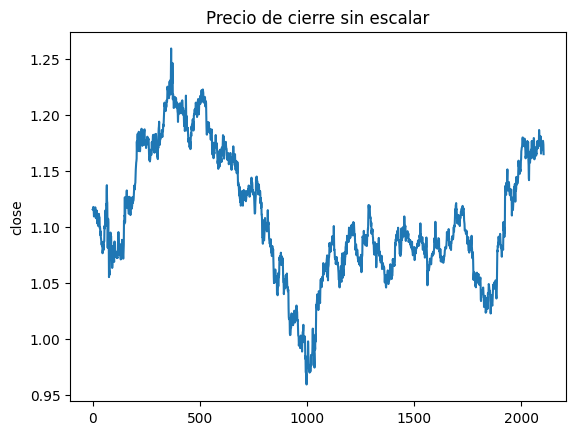

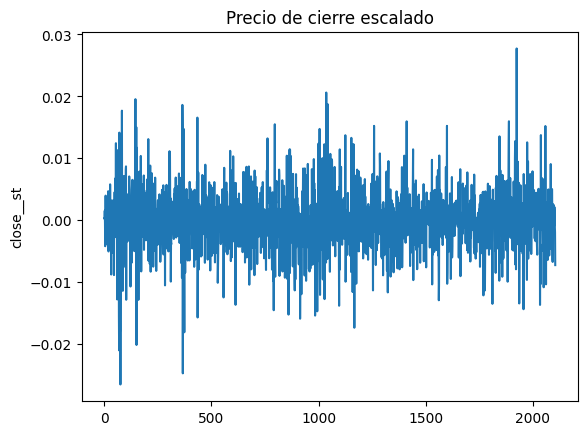

In [33]:
sns.lineplot(df_ohlcv["close"])
plt.title("Precio de cierre sin escalar")
plt.show()
sns.lineplot(df_features["close__st"])
plt.title("Precio de cierre escalado")
plt.show()

In [34]:
# Celda 4: Modelo TimeXer + pipeline de datos + TimeSeriesSplit walk-forward + loaders (+ entrenamiento opcional)

import math
from math import sqrt
import inspect
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# =========================
# Embeddings y máscaras
# =========================
class PositionalEmbedding(nn.Module):
    """
    Embedding posicional sinusoidal clásico.
    """
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model, dtype=torch.float32)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term[:pe[:, 0::2].shape[1]])
        pe[:, 1::2] = torch.cos(position * div_term[:pe[:, 1::2].shape[1]])
        self.register_buffer('pe', pe.unsqueeze(0), persistent=False)  # [1, max_len, d_model]

    def forward(self, x):
        # x: [B, L, D]
        L = x.size(1)
        return self.pe[:, :L, :]


class DataEmbedding_inverted(nn.Module):
    """
    Proyecta exógenas y marcas temporales a d_model y suma embedding posicional.
    Usa LazyLinear para adaptarse a N_exo y d_mark en el primer forward.
    """
    def __init__(self, seq_len, d_model, embed, freq, dropout):
        super().__init__()
        self.value_embedding = nn.LazyLinear(d_model, bias=False)      # inferirá in_features en el forward
        self.temporal_embedding = nn.LazyLinear(d_model, bias=False)
        self.position_embedding = PositionalEmbedding(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, x_mark):
        # x: [B, L, N_exo], x_mark: [B, L, d_mark] o d_mark=0
        v = self.value_embedding(x)
        if (x_mark is not None) and (x_mark.shape[-1] > 0):
            t = self.temporal_embedding(x_mark)
        else:
            t = 0.0
        pos = self.position_embedding(v)
        out = v + (t if isinstance(t, torch.Tensor) else 0.0) + pos
        return self.dropout(out)


class TriangularCausalMask:
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask


class ProbMask:
    def __init__(self, B, H, L, index, scores, device="cpu"):
        _mask = torch.ones(L, scores.shape[-1], dtype=torch.bool).to(device).triu(1)
        _mask_ex = _mask[None, None, :].expand(B, H, L, scores.shape[-1])
        indicator = _mask_ex[torch.arange(B)[:, None, None],
                             torch.arange(H)[None, :, None],
                             index, :].to(device)
        self._mask = indicator.view(scores.shape).to(device)

    @property
    def mask(self):
        return self._mask


# =========================
# Componentes del modelo TimeXer
# =========================
class FlattenHead(nn.Module):
    def __init__(self, n_vars, nf, target_window, head_dropout=0.0):
        super().__init__()
        self.n_vars = n_vars
        self.flatten = nn.Flatten(start_dim=-2)   # aplana [d_model, patch_num+1]
        self.linear = nn.Linear(nf, target_window)
        self.dropout = nn.Dropout(head_dropout)

    def forward(self, x):  # x: [bs x nvars x d_model x patch_num+1]
        x = self.flatten(x)  # [bs x nvars x nf]
        x = self.linear(x)   # [bs x nvars x target_window]
        x = self.dropout(x)
        return x


class EnEmbedding(nn.Module):
    def __init__(self, n_vars, d_model, patch_len, dropout):
        super().__init__()
        self.patch_len = patch_len
        self.value_embedding = nn.Linear(patch_len, d_model, bias=False)
        self.glb_token = nn.Parameter(torch.randn(1, n_vars, 1, d_model))
        self.position_embedding = PositionalEmbedding(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: [B, n_vars, L]
        n_vars = x.shape[1]
        glb = self.glb_token.repeat((x.shape[0], 1, 1, 1))  # [B, n_vars, 1, d_model]

        # Patching: [B, n_vars, L] -> [B, n_vars, patch_num, patch_len]
        x = x.unfold(dimension=-1, size=self.patch_len, step=self.patch_len)
        # Reorganizar a [B*n_vars, patch_num, patch_len]
        x = torch.reshape(x, (x.shape[0] * x.shape[1], x.shape[2], x.shape[3]))
        # Proyección + pos embedding -> [B*n_vars, patch_num, d_model]
        x = self.value_embedding(x) + self.position_embedding(x)
        # Volver a [B, n_vars, patch_num, d_model]
        x = torch.reshape(x, (-1, n_vars, x.shape[-2], x.shape[-1]))
        # Concatenar token global (patch_num+1)
        x = torch.cat([x, glb], dim=2)
        # Aplanar n_vars al batch: [B*n_vars, patch_num+1, d_model]
        x = torch.reshape(x, (x.shape[0] * x.shape[1], x.shape[2], x.shape[3]))
        return self.dropout(x), n_vars


class FullAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super().__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1.0 / sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)

        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)
            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)

        if self.output_attention:
            return V.contiguous(), A
        else:
            return V.contiguous(), None


class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None, d_values=None):
        super().__init__()
        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)
        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries, keys, values, attn_mask,
            tau=tau, delta=delta
        )
        out = out.view(B, L, -1)
        return self.out_projection(out), attn


class EncoderLayer(nn.Module):
    def __init__(self, self_attention, cross_attention, d_model, d_ff=None,
                 dropout=0.1, activation="relu"):
        super().__init__()
        d_ff = d_ff or 4 * d_model
        self.self_attention = self_attention
        self.cross_attention = self_attention if cross_attention is None else cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None, tau=None, delta=None):
        # Self-attention en patches
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask,
            tau=tau, delta=None
        )[0])
        x = self.norm1(x)

        # Cross-attention del token global con exógenas+tiempo
        Bc, Lc, Dc = cross.shape
        x_glb_ori = x[:, -1, :].unsqueeze(1)  # [B*n_vars, 1, D]
        x_glb = torch.reshape(x_glb_ori, (Bc, -1, Dc))  # -> [B, n_vars, D]
        x_glb_attn = self.dropout(self.cross_attention(
            x_glb, cross, cross,
            attn_mask=cross_mask,
            tau=tau, delta=delta
        )[0])
        x_glb_attn = torch.reshape(x_glb_attn, (x_glb_attn.shape[0] * x_glb_attn.shape[1], x_glb_attn.shape[2])).unsqueeze(1)
        x_glb = x_glb_ori + x_glb_attn
        x_glb = self.norm2(x_glb)

        # MLP
        y = x = torch.cat([x[:, :-1, :], x_glb], dim=1)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        return self.norm3(x + y)


class Encoder(nn.Module):
    def __init__(self, layers, norm_layer=None, projection=None):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        self.projection = projection

    def forward(self, x, cross, x_mask=None, cross_mask=None, tau=None, delta=None):
        for layer in self.layers:
            x = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask, tau=tau, delta=delta)
        if self.norm is not None:
            x = self.norm(x)
        if self.projection is not None:
            x = self.projection(x)
        return x


class Model(nn.Module):
    """
    TimeXer (encoder-only). En modo 'MS' usa el último canal de x_enc como endógeno.
    """
    def __init__(self, configs):
        super().__init__()
        self.task_name = configs.task_name
        self.features = configs.features           # 'MS' o 'M'
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.use_norm = configs.use_norm
        self.patch_len = configs.patch_len
        self.patch_num = int(configs.seq_len // configs.patch_len)
        self.n_vars = 1 if configs.features == 'MS' else configs.enc_in

        # Embeddings
        self.en_embedding = EnEmbedding(self.n_vars, configs.d_model, self.patch_len, configs.dropout)
        self.ex_embedding = DataEmbedding_inverted(configs.seq_len, configs.d_model, configs.embed, configs.freq, configs.dropout)

        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        FullAttention(False, configs.factor, attention_dropout=configs.dropout, output_attention=False),
                        configs.d_model, configs.n_heads
                    ),
                    AttentionLayer(
                        FullAttention(False, configs.factor, attention_dropout=configs.dropout, output_attention=False),
                        configs.d_model, configs.n_heads
                    ),
                    configs.d_model,
                    configs.d_ff,
                    dropout=configs.dropout,
                    activation=configs.activation,
                )
                for _ in range(configs.e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(configs.d_model)
        )
        self.head_nf = configs.d_model * (self.patch_num + 1)
        self.head = FlattenHead(configs.enc_in if configs.features != 'MS' else 1, self.head_nf, configs.pred_len,
                                head_dropout=configs.dropout)

    def forecast(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        if self.use_norm:
            means = x_enc.mean(1, keepdim=True).detach()
            x_enc = x_enc - means
            stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
            x_enc /= stdev

        # x_enc: [B, L, N], último canal es endógeno
        en_embed, n_vars = self.en_embedding(x_enc[:, :, -1].unsqueeze(-1).permute(0, 2, 1))  # [B*n_vars, patch_num+1, d_model]
        ex_embed = self.ex_embedding(x_enc[:, :, :-1], x_mark_enc)  # [B, L, d_model]

        enc_out = self.encoder(en_embed, ex_embed)
        enc_out = torch.reshape(enc_out, (-1, n_vars, enc_out.shape[-2], enc_out.shape[-1]))  # [B, nvars, patch_num+1, d_model]
        enc_out = enc_out.permute(0, 1, 3, 2)  # [B, nvars, d_model, patch_num+1]

        dec_out = self.head(enc_out)           # [B, nvars, pred_len]
        dec_out = dec_out.permute(0, 2, 1)     # [B, pred_len, nvars]

        if self.use_norm:
            dec_out = dec_out * (stdev[:, 0, -1:].unsqueeze(1).repeat(1, self.pred_len, 1))
            dec_out = dec_out + (means[:, 0, -1:].unsqueeze(1).repeat(1, self.pred_len, 1))
        return dec_out

    def forecast_multi(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        if self.use_norm:
            means = x_enc.mean(1, keepdim=True).detach()
            x_enc = x_enc - means
            stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
            x_enc /= stdev

        en_embed, n_vars = self.en_embedding(x_enc.permute(0, 2, 1))   # [B*n_vars, patch_num+1, d_model]
        ex_embed = self.ex_embedding(x_enc, x_mark_enc)                # [B, L, d_model]

        enc_out = self.encoder(en_embed, ex_embed)
        enc_out = torch.reshape(enc_out, (-1, n_vars, enc_out.shape[-2], enc_out.shape[-1]))
        enc_out = enc_out.permute(0, 1, 3, 2)

        dec_out = self.head(enc_out)     # [B, nvars, pred_len]
        dec_out = dec_out.permute(0, 2, 1)

        if self.use_norm:
            dec_out = dec_out * (stdev[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))
            dec_out = dec_out + (means[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))
        return dec_out

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None):
        if self.task_name in ('long_term_forecast', 'short_term_forecast'):
            if self.features == 'M':
                dec_out = self.forecast_multi(x_enc, x_mark_enc, x_dec, x_mark_dec)
                return dec_out[:, -self.pred_len:, :]  # [B, L, D]
            else:
                dec_out = self.forecast(x_enc, x_mark_enc, x_dec, x_mark_dec)
                return dec_out[:, -self.pred_len:, :]  # [B, L, D]
        else:
            return None

# Alias
TimeXer = Model


# =========================
# Utils de datos: marcas temporales, ventanas y TimeSeriesSplit
# =========================
def _infer_datetime_index(df_ohlcv: pd.DataFrame) -> pd.DatetimeIndex:
    """
    Devuelve un DatetimeIndex consistente.
    - Usa 'datetime' si existe, luego 'timestamp' (ms), luego index si ya es datetime.
    - Si nada sirve, crea un rango diario ficticio.
    """
    if 'datetime' in df_ohlcv.columns:
        try:
            ser = pd.to_datetime(df_ohlcv['datetime'], utc=True)
            return pd.DatetimeIndex(ser)
        except Exception:
            pass
    if isinstance(df_ohlcv.index, pd.DatetimeIndex):
        return df_ohlcv.index
    if 'timestamp' in df_ohlcv.columns:
        try:
            ser = pd.to_datetime(df_ohlcv['timestamp'], unit='ms', utc=True)
            return pd.DatetimeIndex(ser)
        except Exception:
            pass
    return pd.date_range(start="2000-01-01", periods=len(df_ohlcv), freq="D", tz="UTC")


def build_time_markers_from_index(dti) -> np.ndarray:
    """
    Construye features temporales normalizados: month/12, day/31, weekday/6, hour/23.
    Acepta DatetimeIndex o Serie de timestamps.
    """
    if not isinstance(dti, pd.DatetimeIndex):
        dti = pd.DatetimeIndex(pd.to_datetime(dti, utc=True))
    month = (dti.month.values.astype(np.float32) / 12.0)
    day = (dti.day.values.astype(np.float32) / 31.0)
    weekday = (dti.dayofweek.values.astype(np.float32) / 6.0)
    hour = (dti.hour.values.astype(np.float32) / 23.0)
    hour = np.nan_to_num(hour, nan=0.0)
    return np.stack([month, day, weekday, hour], axis=1).astype(np.float32)


def build_sliding_windows(X: np.ndarray,
                          y: np.ndarray,
                          x_mark_all: np.ndarray,
                          seq_len: int,
                          pred_len: int,
                          drop_nan_windows: bool = True):
    """
    Genera ventanas:
    - X_seq: [M, seq_len, N]
    - y_seq: [M, pred_len]
    - x_mark_seq: [M, seq_len, d_mark]
    """
    T, N = X.shape
    M = T - seq_len - pred_len + 1
    X_list, y_list, xm_list = [], [], []

    for t in range(M):
        x_win = X[t:t + seq_len]
        y_win = y[t + seq_len:t + seq_len + pred_len]
        xm_win = x_mark_all[t:t + seq_len] if x_mark_all is not None else None

        if drop_nan_windows:
            has_nan = np.isnan(x_win).any() or np.isnan(y_win).any() or (xm_win is not None and np.isnan(xm_win).any())
            if has_nan:
                continue

        X_list.append(x_win.astype(np.float32))
        y_list.append(y_win.astype(np.float32))
        if xm_win is not None:
            xm_list.append(xm_win.astype(np.float32))

    X_seq = np.stack(X_list, axis=0) if len(X_list) > 0 else np.empty((0, seq_len, N), dtype=np.float32)
    y_seq = np.stack(y_list, axis=0) if len(y_list) > 0 else np.empty((0, pred_len), dtype=np.float32)
    x_mark_seq = np.stack(xm_list, axis=0) if (x_mark_all is not None and len(xm_list) > 0) else None
    return X_seq, y_seq, x_mark_seq


class TimeSeriesWindowDataset(Dataset):
    """
    Dataset para TimeXer:
    Devuelve (x_enc, x_mark_enc, x_dec, x_mark_dec, y)
    """
    def __init__(self, X_seq: np.ndarray, y_seq: np.ndarray, x_mark_seq: np.ndarray, pred_len: int):
        self.X_seq = X_seq
        self.y_seq = y_seq
        self.x_mark_seq = x_mark_seq
        self.pred_len = pred_len
        self.N = X_seq.shape[2]
        self.d_mark = x_mark_seq.shape[2] if x_mark_seq is not None else 0

    def __len__(self):
        return self.X_seq.shape[0]

    def __getitem__(self, idx):
        x_enc = torch.from_numpy(self.X_seq[idx])                 # [L, N]
        x_mark_enc = torch.from_numpy(self.x_mark_seq[idx]) if self.x_mark_seq is not None else torch.zeros((x_enc.shape[0], 0), dtype=torch.float32)
        x_dec = torch.zeros((self.pred_len, self.N), dtype=torch.float32)
        x_mark_dec = torch.zeros((self.pred_len, self.d_mark), dtype=torch.float32) if self.d_mark > 0 else torch.zeros((self.pred_len, 0), dtype=torch.float32)
        y = torch.from_numpy(self.y_seq[idx])                     # [pred_len]
        return x_enc, x_mark_enc, x_dec, x_mark_dec, y


def pick_patch_len(seq_len: int) -> int:
    """
    patch_len debe dividir seq_len. Elegimos el mayor entre {64,32,16,8,4} que lo cumpla.
    """
    for p in [64, 32, 16, 8, 4]:
        if seq_len % p == 0:
            return p
    return 1


# =========================
# Construcción de matrices X,y y marcas temporales
# =========================
TARGET_COL = "close__st"
assert TARGET_COL in df_features.columns, f"No existe {TARGET_COL} en df_features."

st_cols = [c for c in df_features.columns if c.endswith("__st")]
exo_cols = [c for c in st_cols if c != TARGET_COL]
X_cols = exo_cols + [TARGET_COL]  # target como último canal

X_all = df_features[X_cols].astype(np.float32).values  # [T, N]
y_all = df_features[TARGET_COL].astype(np.float32).values  # [T]

dti = _infer_datetime_index(df_ohlcv)
x_mark_all = build_time_markers_from_index(dti)  # [T, d_mark]

print(f"Número de features estacionarias (incluye target): {len(X_cols)} (target al final)")


# =========================
# Generación de ventanas
# =========================
# Sugerencias por timeframe
if TIMEFRAME == "1h":
    seq_len = 168   # 7 días de historial
    pred_len = 24   # 1 día de predicción
elif TIMEFRAME == "1d":
    seq_len = 128
    pred_len = 7
else:
    seq_len = 128
    pred_len = 16

X_seq, y_seq, x_mark_seq = build_sliding_windows(
    X=X_all, y=y_all, x_mark_all=x_mark_all,
    seq_len=seq_len, pred_len=pred_len, drop_nan_windows=True
)

print(f"Ventanas: X_seq={X_seq.shape}, y_seq={y_seq.shape}, x_mark_seq={None if x_mark_seq is None else x_mark_seq.shape}")
M = X_seq.shape[0]
assert M > 0, "No hay ventanas suficientes; revisa seq_len/pred_len o NaNs."


# =========================
# TimeSeriesSplit (sklearn) para walk-forward
# =========================
try:
    from sklearn.model_selection import TimeSeriesSplit
except ImportError as e:
    raise ImportError("Necesitas scikit-learn para usar TimeSeriesSplit. Instala con: pip install scikit-learn") from e

n_splits = 5
val_size_windows = max(64, int(0.1 * M))  # tamaño de test por fold (si la versión de sklearn lo soporta)

# Detectar si TimeSeriesSplit soporta 'test_size' en esta versión
has_test_size = 'test_size' in inspect.signature(TimeSeriesSplit.__init__).parameters

if has_test_size:
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=val_size_windows, gap=0)
else:
    # Fallback: sin test_size (sklearn más antiguo). El tamaño de test lo decide internamente.
    tscv = TimeSeriesSplit(n_splits=n_splits)

splits = list(tscv.split(np.arange(M)))
print(f"Total folds (TimeSeriesSplit): {len(splits)}")
for i, (tr, va) in enumerate(splits, start=1):
    print(f"Fold {i}: train={len(tr)} ventanas, val={len(va)} ventanas")

def make_loaders_for_split(tr_idx, va_idx, batch_size=64, num_workers=0):
    ds_tr = TimeSeriesWindowDataset(X_seq[tr_idx], y_seq[tr_idx], x_mark_seq[tr_idx], pred_len=pred_len)
    ds_va = TimeSeriesWindowDataset(X_seq[va_idx], y_seq[va_idx], x_mark_seq[va_idx], pred_len=pred_len)
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=False)
    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
    return dl_tr, dl_va

loaders_per_fold = [make_loaders_for_split(tr, va) for (tr, va) in splits]
print("DataLoaders listos.")


# =========================
# Configs del modelo y entrenamiento opcional
# =========================
from types import SimpleNamespace

def timeframe_to_freq_str(tf: str) -> str:
    return "h" if "h" in tf else ("d" if "d" in tf else "h")

def build_configs(enc_in: int, seq_len: int, pred_len: int):
    return SimpleNamespace(
        task_name='short_term_forecast',
        features='MS',                     # último canal es endógeno
        seq_len=seq_len,
        pred_len=pred_len,
        use_norm=True,
        patch_len=pick_patch_len(seq_len),
        d_model=64,
        dropout=0.1,
        embed='timeF',
        freq=timeframe_to_freq_str(TIMEFRAME),
        factor=5,
        n_heads=8,
        d_ff=256,
        e_layers=2,
        activation='gelu',
        enc_in=enc_in
    )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Entrenamiento opcional
RUN_TRAINING = True # pon True si quieres entrenar ahora

if RUN_TRAINING and len(loaders_per_fold) > 0:
    import torch.optim as optim

    def train_one_fold(model, dl_tr, dl_va, device, epochs=5, lr=1e-3):
        optimizer = optim.Adam(model.parameters(), lr=lr)
        loss_fn = nn.MSELoss()
        model.to(device)

        best_val = float("inf")
        for ep in range(1, epochs + 1):
            model.train()
            loss_sum, n_batches = 0.0, 0
            for x_enc, x_mark_enc, x_dec, x_mark_dec, y in dl_tr:
                x_enc = x_enc.to(device)           # [B, L, N]
                x_mark_enc = x_mark_enc.to(device) # [B, L, d_mark]
                x_dec = x_dec.to(device)
                x_mark_dec = x_mark_dec.to(device)
                y = y.to(device)                   # [B, pred_len]

                out = model(x_enc, x_mark_enc, x_dec, x_mark_dec)  # [B, pred_len, 1] en 'MS'
                out = out.squeeze(-1)  # [B, pred_len]

                loss = loss_fn(out, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                loss_sum += loss.item()
                n_batches += 1

            # Validación
            model.eval()
            val_sum, val_batches = 0.0, 0
            with torch.no_grad():
                for x_enc, x_mark_enc, x_dec, x_mark_dec, y in dl_va:
                    x_enc = x_enc.to(device)
                    x_mark_enc = x_mark_enc.to(device)
                    x_dec = x_dec.to(device)
                    x_mark_dec = x_mark_dec.to(device)
                    y = y.to(device)
                    out = model(x_enc, x_mark_enc, x_dec, x_mark_dec).squeeze(-1)
                    val_sum += F.mse_loss(out, y).item()
                    val_batches += 1

            tr_loss = loss_sum / max(1, n_batches)
            va_loss = val_sum / max(1, val_batches)
            print(f"Epoch {ep}: train_loss={tr_loss:.6f} | val_loss={va_loss:.6f}")
            best_val = min(best_val, va_loss)
        return best_val

    bests = []
    enc_in = X_seq.shape[2]
    for fold_i, (dl_tr, dl_va) in enumerate(loaders_per_fold, start=1):
        cfg = build_configs(enc_in=enc_in, seq_len=seq_len, pred_len=pred_len)
        model = TimeXer(cfg)
        print(f"\n=== Fold {fold_i}/{len(loaders_per_fold)} ===")
        best_val = train_one_fold(model, dl_tr, dl_va, device, epochs=10, lr=1e-3)
        bests.append(best_val)

    print("\nMejor pérdida de validación por fold:", bests)
    print("Promedio:", np.mean(bests))

print("Listo. Índices temporales corregidos y TimeSeriesSplit aplicado.")

Número de features estacionarias (incluye target): 119 (target al final)
Ventanas: X_seq=(1882, 128, 119), y_seq=(1882, 7), x_mark_seq=(1882, 128, 4)
Total folds (TimeSeriesSplit): 5
Fold 1: train=942 ventanas, val=188 ventanas
Fold 2: train=1130 ventanas, val=188 ventanas
Fold 3: train=1318 ventanas, val=188 ventanas
Fold 4: train=1506 ventanas, val=188 ventanas
Fold 5: train=1694 ventanas, val=188 ventanas
DataLoaders listos.
Device: cuda

=== Fold 1/5 ===
Epoch 1: train_loss=0.000027 | val_loss=0.000023
Epoch 2: train_loss=0.000024 | val_loss=0.000022
Epoch 3: train_loss=0.000023 | val_loss=0.000022
Epoch 4: train_loss=0.000023 | val_loss=0.000022
Epoch 5: train_loss=0.000023 | val_loss=0.000022
Epoch 6: train_loss=0.000022 | val_loss=0.000022
Epoch 7: train_loss=0.000022 | val_loss=0.000022
Epoch 8: train_loss=0.000022 | val_loss=0.000022
Epoch 9: train_loss=0.000022 | val_loss=0.000022
Epoch 10: train_loss=0.000021 | val_loss=0.000022

=== Fold 2/5 ===
Epoch 1: train_loss=0.000027

Device: cuda

=== Entrenando fold 5/5 ===
Epoch 1: train_loss=0.000023 | val_loss=0.000026
Epoch 2: train_loss=0.000021 | val_loss=0.000026
Epoch 3: train_loss=0.000020 | val_loss=0.000026
Epoch 4: train_loss=0.000020 | val_loss=0.000026
Epoch 5: train_loss=0.000020 | val_loss=0.000026
Epoch 6: train_loss=0.000020 | val_loss=0.000027
Epoch 7: train_loss=0.000020 | val_loss=0.000026
Epoch 8: train_loss=0.000020 | val_loss=0.000026
Epoch 9: train_loss=0.000020 | val_loss=0.000026
Epoch 10: train_loss=0.000020 | val_loss=0.000026
Mejor val MSE (loop): 0.000026
Métricas fold 5: MAE=0.0037, MSE=0.0000, RMSE=0.0051, sMAPE(%)=160.0397, R2=-0.0257, DirAcc(%)=52.5773

Resumen de métricas (_st):


,MAE,MSE,RMSE,sMAPE(%),R2,DirAcc(%)
fold,,,,,,
5,0.003677,0.000026,0.005113,160.039749,-0.025723,52.577320


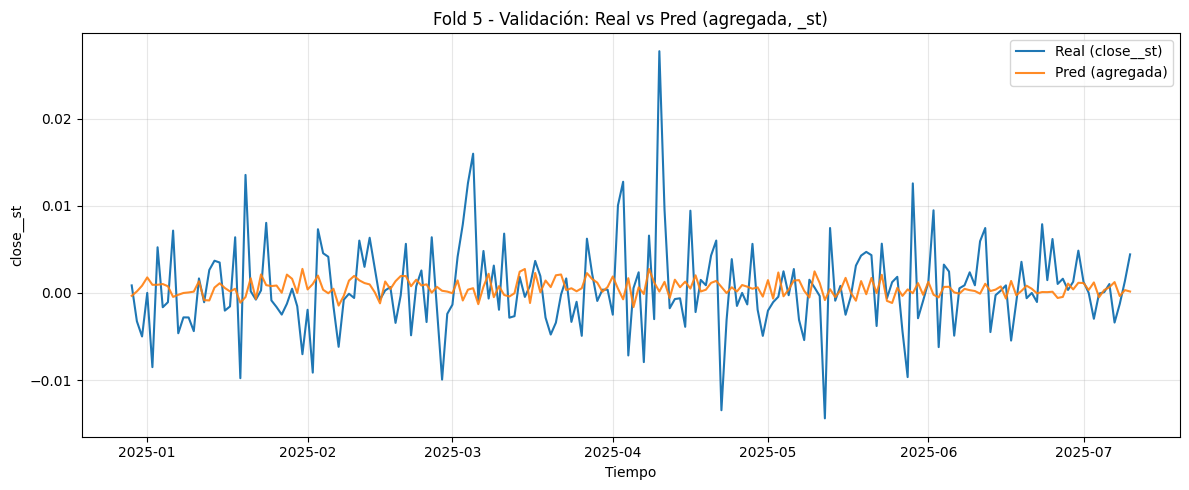

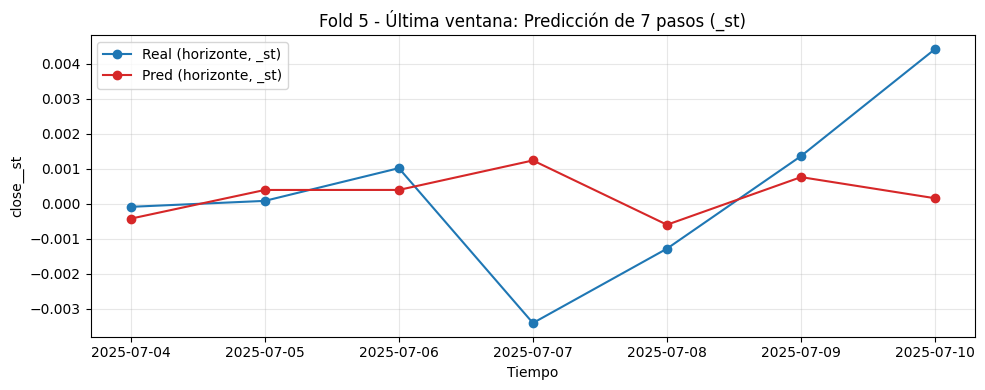

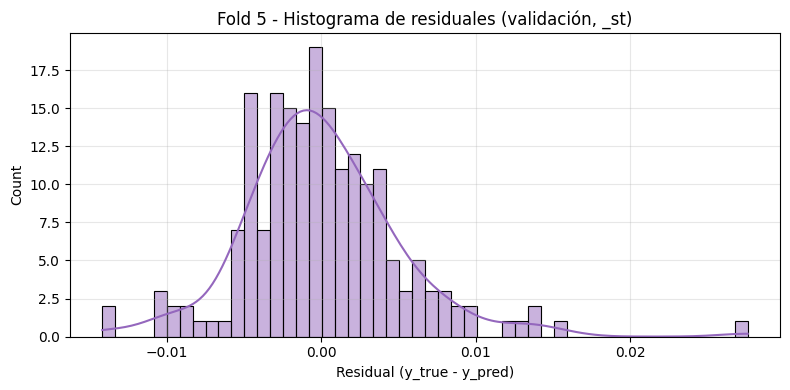


Transformación detectada para close (para invertir): logdiff

Métricas en precio (validación agregada):
- MAE: 0.007002
- MSE: 0.000085
- RMSE: 0.009229
- MAPE(%): 0.639646
- sMAPE(%): 0.640624
- R2: 0.963993
- DirAcc(%): 50.777202


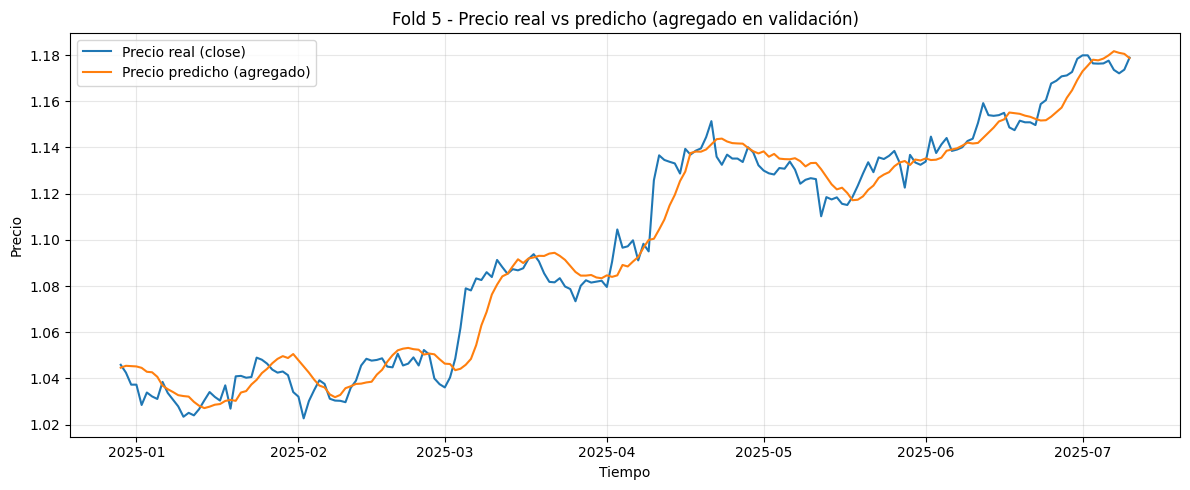

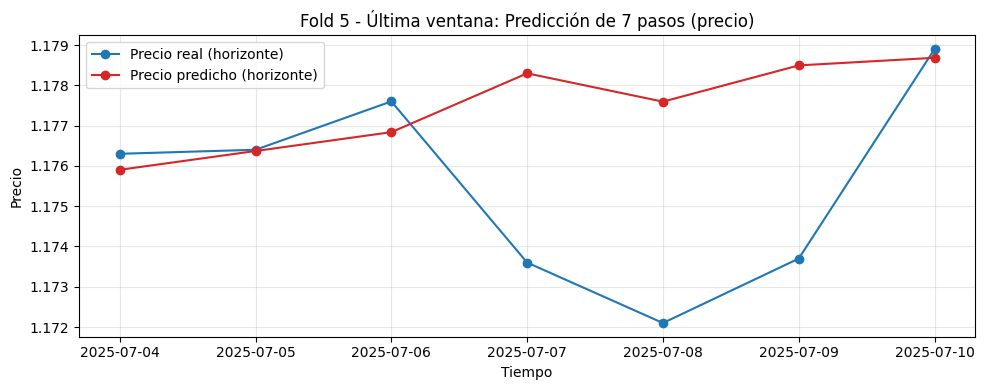

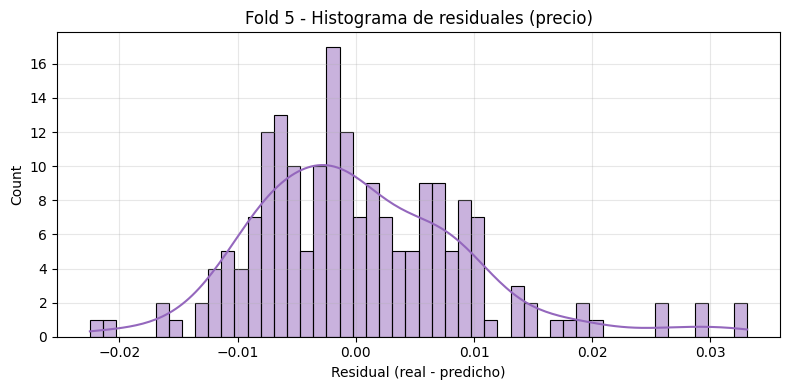

In [35]:
# Celda 5+6: Entrenamiento, forecasting en _st y en precio, métricas y gráficos

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Reproducibilidad (opcional)
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# =========================
# Funciones: entrenamiento, predicción y agregación (_st)
# =========================
def train_one_fold(model, dl_tr, dl_va, device, epochs=8, lr=1e-3, verbose=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    model.to(device)

    best_val = float("inf")
    for ep in range(1, epochs + 1):
        model.train()
        loss_sum, n_batches = 0.0, 0
        for x_enc, x_mark_enc, x_dec, x_mark_dec, y in dl_tr:
            x_enc = x_enc.to(device)           # [B, L, N]
            x_mark_enc = x_mark_enc.to(device) # [B, L, d_mark]
            x_dec = x_dec.to(device)
            x_mark_dec = x_mark_dec.to(device)
            y = y.to(device)                   # [B, pred_len]

            out = model(x_enc, x_mark_enc, x_dec, x_mark_dec).squeeze(-1)  # [B, pred_len]
            loss = loss_fn(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
            n_batches += 1

        # Validación
        model.eval()
        val_sum, val_batches = 0.0, 0
        with torch.no_grad():
            for x_enc, x_mark_enc, x_dec, x_mark_dec, y in dl_va:
                x_enc = x_enc.to(device)
                x_mark_enc = x_mark_enc.to(device)
                x_dec = x_dec.to(device)
                x_mark_dec = x_mark_dec.to(device)
                y = y.to(device)
                out = model(x_enc, x_mark_enc, x_dec, x_mark_dec).squeeze(-1)
                val_sum += F.mse_loss(out, y).item()
                val_batches += 1

        tr_loss = loss_sum / max(1, n_batches)
        va_loss = val_sum / max(1, val_batches)
        if verbose:
            print(f"Epoch {ep}: train_loss={tr_loss:.6f} | val_loss={va_loss:.6f}")
        best_val = min(best_val, va_loss)
    return best_val


@torch.no_grad()
def predict_windows(model, window_indices, batch_size=256):
    """
    Devuelve predicciones [len(window_indices), pred_len] en el espacio estacionario para esos índices de ventanas.
    Usa X_seq, x_mark_seq, seq_len, pred_len definidos en la Celda 4.
    """
    model.eval()
    preds_list = []
    for i in range(0, len(window_indices), batch_size):
        inds = window_indices[i:i+batch_size]
        x_enc = torch.from_numpy(X_seq[inds]).to(device)             # [B, L, N]
        x_mark_enc = torch.from_numpy(x_mark_seq[inds]).to(device)   # [B, L, d_mark]
        x_dec = torch.zeros((x_enc.size(0), pred_len, x_enc.size(2)), dtype=torch.float32, device=device)
        x_mark_dec = torch.zeros((x_enc.size(0), pred_len, x_mark_enc.size(2)), dtype=torch.float32, device=device)

        out = model(x_enc, x_mark_enc, x_dec, x_mark_dec).squeeze(-1)  # [B, pred_len]
        preds_list.append(out.detach().cpu().numpy())
    return np.vstack(preds_list) if len(preds_list) > 0 else np.empty((0, pred_len), dtype=np.float32)


def aggregate_predictions(window_indices, preds, T, seq_len, pred_len):
    """
    Agrega predicciones por superposición en la serie temporal original (índices de y_all).
    Devuelve y_pred_agg [T] con NaN donde no hay predicciones, y counts [T].
    """
    sums = np.zeros(T, dtype=np.float64)
    counts = np.zeros(T, dtype=np.int32)

    for i, start in enumerate(window_indices):
        for k in range(pred_len):
            t_idx = start + seq_len + k
            if 0 <= t_idx < T:
                sums[t_idx] += float(preds[i, k])
                counts[t_idx] += 1

    y_pred_agg = np.full(T, np.nan, dtype=np.float32)
    valid = counts > 0
    y_pred_agg[valid] = (sums[valid] / counts[valid]).astype(np.float32)
    return y_pred_agg, counts


def compute_metrics(y_true, y_pred):
    """
    Métricas en espacio estacionario.
    """
    eps = 1e-8
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    yt = y_true[mask]
    yp = y_pred[mask]
    if yt.size == 0:
        return {"MAE": np.nan, "MSE": np.nan, "RMSE": np.nan, "sMAPE(%)": np.nan, "R2": np.nan, "DirAcc(%)": np.nan}

    mae = np.mean(np.abs(yp - yt))
    mse = np.mean((yp - yt) ** 2)
    rmse = np.sqrt(mse)
    smape = 100.0 * np.mean(2.0 * np.abs(yp - yt) / (np.abs(yt) + np.abs(yp) + eps))
    ss_res = np.sum((yt - yp) ** 2)
    ss_tot = np.sum((yt - yt.mean()) ** 2) + eps
    r2 = 1.0 - ss_res / ss_tot
    dir_acc = 100.0 * np.mean(np.sign(yt) == np.sign(yp))

    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "sMAPE(%)": smape, "R2": r2, "DirAcc(%)": dir_acc}


# =========================
# Entrenamiento y evaluación en _st
# =========================
EPOCHS = 10
LR = 1e-3
RUN_ALL_FOLDS = False  # True para entrenar/evaluar todos los folds en espacio _st

fold_indices_to_run = list(range(len(splits))) if RUN_ALL_FOLDS else [len(splits)-1]

metrics_list = []
last_fold_artifacts = {}
last_trained_model = None
last_fold_used = None

for ix, fold_i in enumerate(fold_indices_to_run, start=1):
    tr_idx, va_idx = splits[fold_i]
    dl_tr, dl_va = loaders_per_fold[fold_i]

    cfg = build_configs(enc_in=X_seq.shape[2], seq_len=seq_len, pred_len=pred_len)
    model = TimeXer(cfg)

    print(f"\n=== Entrenando fold {fold_i+1}/{len(splits)} ===")
    best_val = train_one_fold(model, dl_tr, dl_va, device, epochs=EPOCHS, lr=LR, verbose=True)
    print(f"Mejor val MSE (loop): {best_val:.6f}")

    # Predicción en ventanas de validación (espacio _st)
    preds = predict_windows(model, va_idx, batch_size=256)  # [len(va_idx), pred_len]
    # Agregado en la serie temporal (espacio _st)
    T_tot = len(y_all)
    y_pred_agg, counts = aggregate_predictions(va_idx, preds, T_tot, seq_len, pred_len)

    # Métricas en validación (_st)
    val_mask = counts > 0
    fold_metrics = compute_metrics(y_all[val_mask], y_pred_agg[val_mask])
    fold_metrics["fold"] = fold_i + 1
    metrics_list.append(fold_metrics)
    print(f"Métricas fold {fold_i+1}: " +
          ", ".join([f"{k}={v:.4f}" for k,v in fold_metrics.items() if k!='fold']))

    # Guardar artefactos del último fold corrido
    last_fold_artifacts = dict(
        fold=fold_i+1,
        va_idx=va_idx,
        preds_st=preds,
        y_pred_agg_st=y_pred_agg,
        counts_st=counts
    )
    last_trained_model = model
    last_fold_used = fold_i

# Resumen de métricas (_st)
df_metrics = pd.DataFrame(metrics_list).set_index("fold")
print("\nResumen de métricas (_st):")
display(df_metrics.style.format("{:.6f}"))

if RUN_ALL_FOLDS and len(df_metrics) > 1:
    print("\nPromedio sobre folds (_st):")
    display(df_metrics.mean().to_frame("mean").T.style.format("{:.6f}"))

# -------------------------
# Gráficos (_st) del último fold ejecutado
# -------------------------
if last_fold_artifacts:
    fold = last_fold_artifacts["fold"]
    y_pred_agg_st = last_fold_artifacts["y_pred_agg_st"]
    counts_st = last_fold_artifacts["counts_st"]
    va_idx = last_fold_artifacts["va_idx"]
    preds_st_lastfold = last_fold_artifacts["preds_st"]

    # Serie de validación agregada
    val_mask = counts_st > 0
    dates_val = dti[val_mask]
    y_true_val = y_all[val_mask]
    y_pred_val = y_pred_agg_st[val_mask]

    # 1) Curva real vs predicha (agregada) en validación (_st)
    plt.figure(figsize=(12, 5))
    plt.plot(dates_val, y_true_val, label="Real (close__st)", color="#1f77b4", linewidth=1.5)
    plt.plot(dates_val, y_pred_val, label="Pred (agregada)", color="#ff7f0e", linewidth=1.5, alpha=0.9)
    plt.title(f"Fold {fold} - Validación: Real vs Pred (agregada, _st)")
    plt.xlabel("Tiempo")
    plt.ylabel("close__st")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 2) Última ventana del fold: horizonte completo (_st)
    last_win = va_idx[-1]
    t_range = np.arange(last_win + seq_len, last_win + seq_len + pred_len)
    t_range = t_range[t_range < len(y_all)]
    dates_h = dti[t_range]
    y_true_h = y_all[t_range]
    y_pred_h = preds_st_lastfold[-1][:len(t_range)]  # última ventana

    plt.figure(figsize=(10, 4))
    plt.plot(dates_h, y_true_h, marker="o", label="Real (horizonte, _st)", color="#1f77b4")
    plt.plot(dates_h, y_pred_h, marker="o", label="Pred (horizonte, _st)", color="#d62728")
    plt.title(f"Fold {fold} - Última ventana: Predicción de {pred_len} pasos (_st)")
    plt.xlabel("Tiempo")
    plt.ylabel("close__st")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 3) Histograma de residuales en validación (_st)
    residuals = y_true_val - y_pred_val
    plt.figure(figsize=(8, 4))
    sns.histplot(residuals, bins=50, kde=True, color="#9467bd")
    plt.title(f"Fold {fold} - Histograma de residuales (validación, _st)")
    plt.xlabel("Residual (y_true - y_pred)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No hay artefactos del fold para graficar en _st. Verifica el loop de entrenamiento.")

# =========================
# Inversión a precios y evaluación/plots en precio (usando el último fold entrenado)
# =========================
def detect_transform_for_series(s: pd.Series) -> str:
    non_na = s.dropna()
    if non_na.empty:
        return "diff"  # fallback
    if (non_na > 0).all():
        return "logdiff"   # log(x).diff()
    elif (non_na >= 0).all():
        return "log1pdiff" # log1p(x).diff()
    else:
        return "diff"      # x.diff()

def invert_step(prev_x: float, st_pred: float, transform: str) -> float:
    if np.isnan(prev_x) or np.isnan(st_pred):
        return np.nan
    if transform == "logdiff":
        return float(prev_x * np.exp(st_pred))
    elif transform == "log1pdiff":
        return float(np.exp(st_pred) * (1.0 + prev_x) - 1.0)
    else:  # diff
        return float(prev_x + st_pred)

def metrics_price(y_true, y_pred):
    eps = 1e-8
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    yt = y_true[mask]
    yp = y_pred[mask]
    if yt.size == 0:
        return {"MAE": np.nan, "MSE": np.nan, "RMSE": np.nan, "MAPE(%)": np.nan, "sMAPE(%)": np.nan, "R2": np.nan, "DirAcc(%)": np.nan}
    mae = np.mean(np.abs(yp - yt))
    mse = np.mean((yp - yt) ** 2)
    rmse = np.sqrt(mse)
    mape = 100.0 * np.mean(np.abs(yp - yt) / (np.abs(yt) + eps))
    smape = 100.0 * np.mean(2.0 * np.abs(yp - yt) / (np.abs(yt) + np.abs(yp) + eps))
    ss_res = np.sum((yt - yp) ** 2)
    ss_tot = np.sum((yt - yt.mean()) ** 2) + eps
    r2 = 1.0 - ss_res / ss_tot
    dy_true = yt[1:] - yt[:-1]
    dy_pred = yp[1:] - yp[:-1]
    dir_acc = 100.0 * np.mean(np.sign(dy_true) == np.sign(dy_pred)) if len(dy_true) > 0 else np.nan
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE(%)": mape, "sMAPE(%)": smape, "R2": r2, "DirAcc(%)": dir_acc}

if last_fold_artifacts:
    # Serie de precios y tipo de transformación
    transform_close = detect_transform_for_series(df_features["close"].astype(float))
    print(f"\nTransformación detectada para close (para invertir): {transform_close}")
    close_prices = df_features["close"].astype(np.float32).values
    T = len(close_prices)

    va_idx = last_fold_artifacts["va_idx"]
    preds_st = last_fold_artifacts["preds_st"]

    # Reconstrucción de precios por ventana y agregado
    price_sums = np.zeros(T, dtype=np.float64)
    price_counts = np.zeros(T, dtype=np.int32)

    for i, w in enumerate(va_idx):
        base_idx = w + seq_len - 1
        if base_idx < 0 or base_idx >= T:
            continue
        p_prev = close_prices[base_idx]
        for k in range(pred_len):
            t_idx = w + seq_len + k
            if t_idx >= T:
                break
            p_next = invert_step(p_prev, preds_st[i, k], transform_close)
            price_sums[t_idx] += p_next
            price_counts[t_idx] += 1
            p_prev = p_next

    price_pred_agg = np.full(T, np.nan, dtype=np.float32)
    valid_price = price_counts > 0
    price_pred_agg[valid_price] = (price_sums[valid_price] / price_counts[valid_price]).astype(np.float32)

    # Métricas en precio
    price_metrics = metrics_price(close_prices, price_pred_agg)
    print("\nMétricas en precio (validación agregada):")
    for k, v in price_metrics.items():
        print(f"- {k}: {v:.6f}")

    # Gráficos en precio
    dates = dti

    # 1) Curva real vs predicha en validación (precio agregado)
    plt.figure(figsize=(12, 5))
    plt.plot(dates[valid_price], close_prices[valid_price], label="Precio real (close)", color="#1f77b4", linewidth=1.5)
    plt.plot(dates[valid_price], price_pred_agg[valid_price], label="Precio predicho (agregado)", color="#ff7f0e", linewidth=1.5)
    plt.title(f"Fold {last_fold_used+1 if last_fold_used is not None else '?'} - Precio real vs predicho (agregado en validación)")
    plt.xlabel("Tiempo")
    plt.ylabel("Precio")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 2) Última ventana del fold: trayectoria de precios predicha vs real
    last_w = va_idx[-1]
    base_idx = last_w + seq_len - 1
    p_prev = close_prices[base_idx]
    pred_price_path = []
    for k in range(pred_len):
        p_next = invert_step(p_prev, preds_st[-1, k], transform_close)
        pred_price_path.append(p_next)
        p_prev = p_next

    t_range = np.arange(last_w + seq_len, min(last_w + seq_len + pred_len, T))
    dates_h = dates[t_range]
    y_true_h = close_prices[t_range]
    y_pred_h = np.array(pred_price_path[:len(t_range)])

    plt.figure(figsize=(10, 4))
    plt.plot(dates_h, y_true_h, marker="o", label="Precio real (horizonte)", color="#1f77b4")
    plt.plot(dates_h, y_pred_h, marker="o", label="Precio predicho (horizonte)", color="#d62728")
    plt.title(f"Fold {last_fold_used+1 if last_fold_used is not None else '?'} - Última ventana: Predicción de {pred_len} pasos (precio)")
    plt.xlabel("Tiempo")
    plt.ylabel("Precio")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 3) Histograma de residuales en precio (zona de validación)
    resid = close_prices[valid_price] - price_pred_agg[valid_price]
    plt.figure(figsize=(8, 4))
    sns.histplot(resid, bins=50, kde=True, color="#9467bd")
    plt.title(f"Fold {last_fold_used+1 if last_fold_used is not None else '?'} - Histograma de residuales (precio)")
    plt.xlabel("Residual (real - predicho)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No hay artefactos del fold para invertir a precio. Ejecuta el entrenamiento primero.")

Device: cuda
Usando last_trained_model del fold 5
Predicciones (_st) shape: (7,)

Primeras filas del pronóstico (_st):


,datetime,pred_close__st
0,2025-10-08 00:00:00+00:00,0.001038
1,2025-10-09 00:00:00+00:00,0.001814
2,2025-10-10 00:00:00+00:00,-0.000180
3,2025-10-11 00:00:00+00:00,-0.000439
4,2025-10-12 00:00:00+00:00,-0.001101



Primeras filas del pronóstico (precio):


,datetime,pred_price
0,2025-10-08 00:00:00+00:00,1.166210
1,2025-10-09 00:00:00+00:00,1.168327
2,2025-10-10 00:00:00+00:00,1.168116
3,2025-10-11 00:00:00+00:00,1.167604
4,2025-10-12 00:00:00+00:00,1.166319


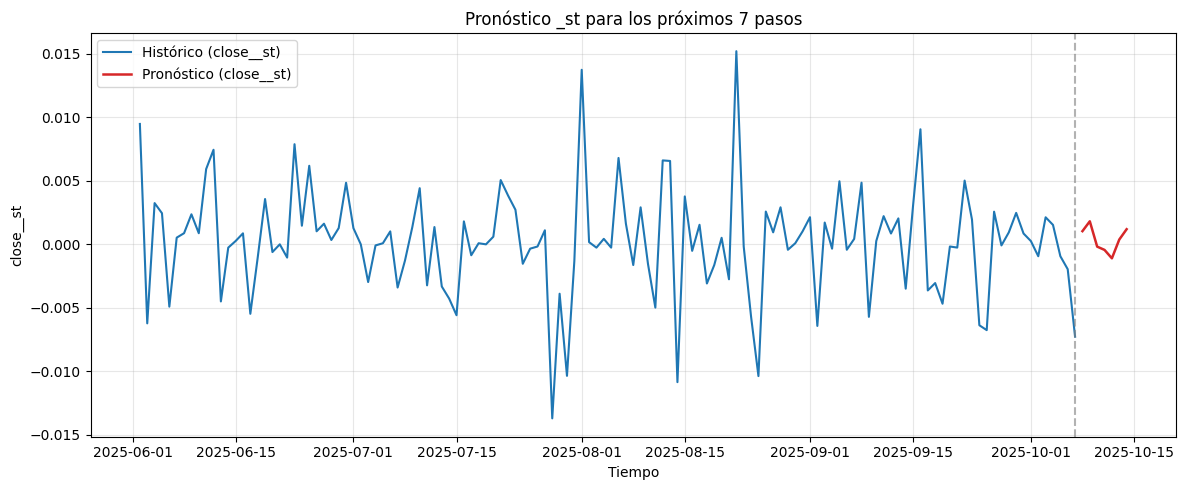

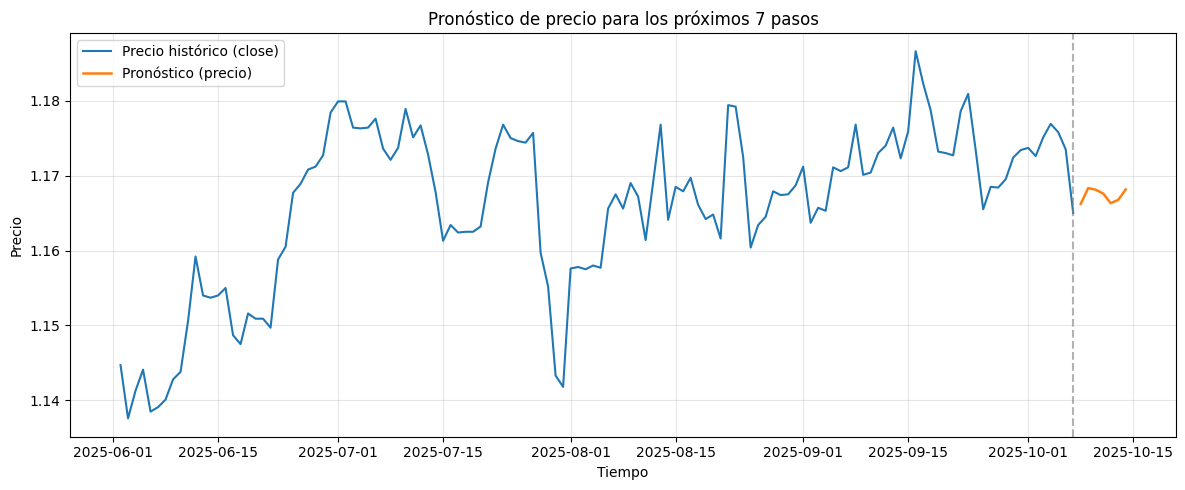

Listo: pronóstico en _st y precio generados desde la última ventana real.


In [36]:
# Celda: Forecast en producción desde el último dato (último fold)
# - Usa last_trained_model si existe; si no, reentrena rápidamente el último fold.
# - Predice el siguiente horizonte pred_len a partir de la última ventana real.
# - Grafica en espacio estacionario (_st) y en precio reintegrado.

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from pandas.tseries.frequencies import to_offset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------
# Comprobar o entrenar modelo del último fold
# -------------------------
def ensure_last_model():
    global last_trained_model, last_fold_used
    if 'last_trained_model' in globals() and last_trained_model is not None:
        last_trained_model.eval()
        last_trained_model.to(device)
        print(f"Usando last_trained_model del fold {last_fold_used+1 if last_fold_used is not None else '?'}")
        return last_trained_model
    # Si no existe, reentrenar en el último fold disponible
    print("Aviso: last_trained_model no encontrado. Reentrenando en el último fold...")
    fold_to_run = len(splits) - 1
    tr_idx, va_idx = splits[fold_to_run]
    dl_tr, dl_va = loaders_per_fold[fold_to_run]
    cfg = build_configs(enc_in=X_seq.shape[2], seq_len=seq_len, pred_len=pred_len)
    model = TimeXer(cfg)
    # Entrenamiento breve
    def _train(m, dl_tr, dl_va, epochs=5, lr=1e-3):
        import torch.nn.functional as F
        import torch.nn as nn
        opt = torch.optim.Adam(m.parameters(), lr=lr)
        loss_fn = nn.MSELoss()
        m.to(device)
        for ep in range(1, epochs+1):
            m.train()
            for x_enc, x_mark_enc, x_dec, x_mark_dec, y in dl_tr:
                x_enc = x_enc.to(device); x_mark_enc = x_mark_enc.to(device)
                x_dec = x_dec.to(device); x_mark_dec = x_mark_dec.to(device); y = y.to(device)
                out = m(x_enc, x_mark_enc, x_dec, x_mark_dec).squeeze(-1)
                loss = loss_fn(out, y)
                opt.zero_grad(); loss.backward(); opt.step()
        m.eval()
        return m
    model = _train(model, dl_tr, dl_va, epochs=5, lr=1e-3)
    last_fold_used = fold_to_run
    return model

model = ensure_last_model()

# -------------------------
# Preparar última ventana de entrada (últimos seq_len pasos)
# -------------------------
# Nota: para producción construimos la ventana desde el final de la serie,
# no la última ventana del conjunto de ventanas (que requiere y futuras).
X_prod = X_all[-seq_len:, :].astype(np.float32)          # [L, N]
x_mark_prod = x_mark_all[-seq_len:, :].astype(np.float32)  # [L, d_mark]

# Seguridad ante NaNs (idealmente no debería haber)
if np.isnan(X_prod).any():
    print("Advertencia: NaNs detectados en la última ventana, se imputan a 0 temporalmente.")
    X_prod = np.nan_to_num(X_prod, nan=0.0)
if np.isnan(x_mark_prod).any():
    x_mark_prod = np.nan_to_num(x_mark_prod, nan=0.0)

# Tensores
x_enc = torch.from_numpy(X_prod).unsqueeze(0).to(device)            # [1, L, N]
x_mark_enc = torch.from_numpy(x_mark_prod).unsqueeze(0).to(device)  # [1, L, d_mark]
x_dec = torch.zeros((1, pred_len, X_prod.shape[1]), dtype=torch.float32, device=device)
x_mark_dec = torch.zeros((1, pred_len, x_mark_prod.shape[1]), dtype=torch.float32, device=device)

# -------------------------
# Predicción en espacio estacionario (_st) para el siguiente horizonte
# -------------------------
with torch.no_grad():
    preds_st = model(x_enc, x_mark_enc, x_dec, x_mark_dec).squeeze(0).squeeze(-1).detach().cpu().numpy()  # [pred_len]

print("Predicciones (_st) shape:", preds_st.shape)

# -------------------------
# Reintegración a precio desde close__st
# -------------------------
def detect_transform_for_series(s: pd.Series) -> str:
    non_na = s.dropna()
    if non_na.empty:
        return "diff"  # fallback
    if (non_na > 0).all():
        return "logdiff"   # log(x).diff()
    elif (non_na >= 0).all():
        return "log1pdiff" # log1p(x).diff()
    else:
        return "diff"      # x.diff()

def invert_step(prev_x: float, st_pred: float, transform: str) -> float:
    if np.isnan(prev_x) or np.isnan(st_pred):
        return np.nan
    if transform == "logdiff":
        return float(prev_x * np.exp(st_pred))
    elif transform == "log1pdiff":
        return float(np.exp(st_pred) * (1.0 + prev_x) - 1.0)
    else:  # diff
        return float(prev_x + st_pred)

transform_close = detect_transform_for_series(df_features["close"].astype(float))
last_price = float(df_features["close"].iloc[-1])
pred_price_path = []
p_prev = last_price
for k in range(pred_len):
    p_next = invert_step(p_prev, preds_st[k], transform_close)
    pred_price_path.append(p_next)
    p_prev = p_next
pred_price_path = np.array(pred_price_path, dtype=np.float32)

# -------------------------
# Fechas futuras con la misma frecuencia del dataset
# -------------------------
try:
    offset = to_offset(TIMEFRAME)
except Exception:
    offset = to_offset("1H" if "h" in TIMEFRAME.lower() else "1D")

tz = getattr(dti, "tz", None)
future_index = pd.date_range(start=dti[-1] + offset, periods=pred_len, freq=offset, tz=tz)

# -------------------------
# Tablas rápidas de resultados
# -------------------------
df_forecast_st = pd.DataFrame({"datetime": future_index, "pred_close__st": preds_st})
df_forecast_price = pd.DataFrame({"datetime": future_index, "pred_price": pred_price_path})
print("\nPrimeras filas del pronóstico (_st):")
display(df_forecast_st.head())
print("\nPrimeras filas del pronóstico (precio):")
display(df_forecast_price.head())

# -------------------------
# Gráfico 1: _st (histórico reciente + pronóstico)
# -------------------------
hist_len = min(seq_len, len(y_all))
plt.figure(figsize=(12, 5))
plt.plot(dti[-hist_len:], y_all[-hist_len:], label="Histórico (close__st)", color="#1f77b4", linewidth=1.5)
plt.plot(future_index, preds_st, label="Pronóstico (close__st)", color="#d62728", linewidth=1.8)
plt.axvline(dti[-1], color="gray", linestyle="--", alpha=0.6)
plt.title(f"Pronóstico _st para los próximos {pred_len} pasos")
plt.xlabel("Tiempo"); plt.ylabel("close__st"); plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# -------------------------
# Gráfico 2: Precio (histórico reciente + pronóstico en precio)
# -------------------------
close_prices = df_features["close"].astype(np.float32).values
hist_len_price = min(seq_len, len(close_prices))
plt.figure(figsize=(12, 5))
plt.plot(dti[-hist_len_price:], close_prices[-hist_len_price:], label="Precio histórico (close)", color="#1f77b4", linewidth=1.5)
plt.plot(future_index, pred_price_path, label="Pronóstico (precio)", color="#ff7f0e", linewidth=1.8)
plt.axvline(dti[-1], color="gray", linestyle="--", alpha=0.6)
plt.title(f"Pronóstico de precio para los próximos {pred_len} pasos")
plt.xlabel("Tiempo"); plt.ylabel("Precio"); plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

print("Listo: pronóstico en _st y precio generados desde la última ventana real.")